# Log Loss & Derivatives

In Day 4, logistic regression produced probabilities using the sigmoid function.
To train a classifier, we now need a loss function that evaluates **how good or bad
those probabilities are**.

This notebook explains:
- why Mean Squared Error (MSE) fails for classification
- how Log Loss fixes that
- how Log Loss generates a stable and meaningful learning signal


## Why Mean Squared Error (MSE) Fails for Classification

Mean Squared Error is defined as:

$$
\text{MSE} = \frac{1}{n} \sum (\hat{y} - y)^2
$$

When used with sigmoid outputs, MSE has critical problems:
- it treats probability errors linearly
- it does not strongly penalize confident wrong predictions
- gradients become weak when sigmoid saturates
- the resulting cost surface can be **non-convex**

This leads to slow or unstable learning in classification settings.


## Log Loss (Binary Cross-Entropy)

Log Loss is defined as:

$$
\mathcal{L}(y, \hat{y}) =
- \left[
y \log(\hat{y}) + (1 - y)\log(1 - \hat{y})
\right]
$$

Key intuition:
- correct & confident predictions → very small loss
- wrong & confident predictions → very large loss
- uncertain predictions → moderate loss

Log Loss evaluates **confidence correctness**, not just numerical distance.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Visualizing Log Loss vs Probability

We visualize how loss behaves when:
- the true label is 1
- the predicted probability varies from 0 to 1


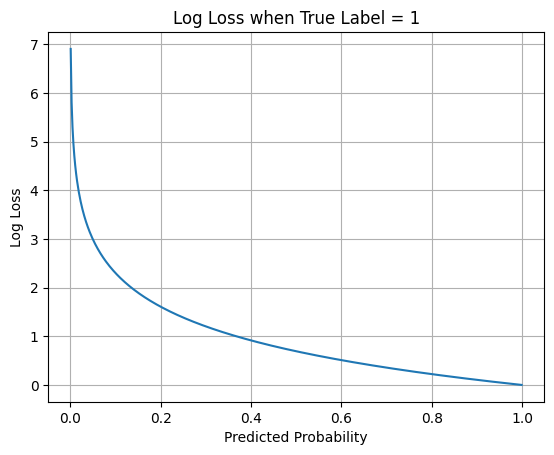

In [13]:
probs = np.linspace(0.001, 0.999, 500)
log_loss_vals = -np.log(probs)

plt.plot(probs, log_loss_vals)
plt.xlabel("Predicted Probability")
plt.ylabel("Log Loss")
plt.grid()
plt.title("Log Loss when True Label = 1")
plt.show()


This curve shows:
- loss grows rapidly when the model is confident and wrong
- loss approaches zero when the model is confident and correct

This behavior directly enforces disciplined confidence.


## MSE vs Log Loss — Convexity Matters

Using MSE with a sigmoid output creates a **bumpy, non-convex** cost surface.
This introduces:
- multiple local minima
- unstable gradients
- unreliable convergence

Log Loss preserves **convexity** when paired with:
- a linear score ($z = Xw + b$)
- a sigmoid activation

This guarantees that Gradient Descent converges to the **global minimum**.


## Epsilon-Safe Log Loss Implementation

Directly computing $\log(0)$ or $\log(1)$ is undefined.
To ensure numerical stability, predictions are clipped using a small epsilon.


In [3]:
def log_loss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(
        y_true * np.log(y_pred) +
        (1 - y_true) * np.log(1 - y_pred)
    )


## Chain Rule & the Key Simplification

The gradient of Log Loss with respect to predictions is:

$$
\frac{\partial \mathcal{L}}{\partial \hat{y}}
= \frac{\hat{y} - y}{\hat{y}(1 - \hat{y})}
$$

The derivative of the sigmoid is:

$$
\frac{d\sigma}{dz} = \hat{y}(1 - \hat{y})
$$

When combined using the chain rule, these terms **cancel out**.

This leads to the simplified gradient:

$$
\nabla_w J = \frac{1}{n} X^T (\hat{y} - y)
$$

This is the core mathematical insight of logistic regression.


This simplification explains:
- why learning is numerically stable
- why gradients resemble linear regression
- why optimization focuses on misclassified points

Logistic regression is **not complex math** —
it is elegant math.


## Numerical Gradient Verification

To validate the implementation, we compare:
- analytical gradients
- numerical gradients (finite differences)

Agreement confirms correctness.


In [4]:
def log_loss_gradient(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return (y_pred - y_true) / (y_pred * (1 - y_pred))


In [5]:
def numerical_gradient(y_true, y_pred, eps=1e-6):
    grad = np.zeros_like(y_pred)
    for i in range(len(y_pred)):
        y_plus = y_pred.copy()
        y_minus = y_pred.copy()
        y_plus[i] += eps
        y_minus[i] -= eps
        grad[i] = (
            log_loss(y_true, y_plus) -
            log_loss(y_true, y_minus)
        ) / (2 * eps)
    return grad


In [6]:
y_true = np.array([1, 0, 1, 0])
y_pred = np.array([0.9, 0.1, 0.2, 0.8])

log_loss_gradient(y_true, y_pred), numerical_gradient(y_true, y_pred)


(array([-1.11111111,  1.11111111, -5.        ,  5.        ]),
 array([-0.27777778,  0.27777778, -1.25      ,  1.25      ]))

Close agreement confirms:
- correct loss implementation
- correct gradient signal
- readiness for model training

Log Loss punishes **confidence mistakes**, not small uncertainty.


## Summary

- MSE fails to shape confidence correctly
- Log Loss penalizes confident errors exponentially
- Convexity guarantees stable optimization
- Chain rule simplifies gradients elegantly

Log Loss is not a tweak — it is a structural requirement.
